In [ ]:
from typing import List, Dict, Any, Optional
import openai
from pydantic import BaseModel
import json

class Agent:
    def __init__(self, api_key: str, model: str = "gpt-4"):
        """
        Initialize the AI Agent
        
        Args:
            api_key: OpenAI API key
            model: Model to use (default: gpt-4)
        """
        self.api_key = api_key
        self.model = model
        openai.api_key = api_key
        self.conversation_history = []
        
    def add_to_history(self, role: str, content: str):
        """Add a message to the conversation history"""
        self.conversation_history.append({"role": role, "content": content})
    
    def clear_history(self):
        """Clear the conversation history"""
        self.conversation_history = []
        
    async def think(self, task: str, temperature: float = 0.7) -> str:
        """
        Process the task and generate a response
        
        Args:
            task: The task or question to process
            temperature: Controls randomness in the response (0.0 to 1.0)
            
        Returns:
            str: The agent's response
        """
        # Add the new task to conversation history
        self.add_to_history("user", task)
        
        try:
            response = await openai.ChatCompletion.acreate(
                model=self.model,
                messages=self.conversation_history,
                temperature=temperature
            )
            
            # Extract the response
            answer = response.choices[0].message.content
            
            # Add the response to conversation history
            self.add_to_history("assistant", answer)
            
            return answer
            
        except Exception as e:
            return f"Error: {str(e)}"
    
    async def execute_task(self, task: str, tools: List[Dict[str, Any]] = None) -> str:
        """
        Execute a task with available tools
        
        Args:
            task: The task to execute
            tools: List of available tools/functions
            
        Returns:
            str: The result of the task execution
        """
        system_prompt = """You are a helpful AI assistant that can use tools to accomplish tasks. 
        When you need to use a tool, respond with a JSON object containing 'tool' and 'parameters'.
        If no tool is needed, respond normally."""
        
        self.add_to_history("system", system_prompt)
        
        response = await self.think(task)
        
        try:
            # Try to parse response as JSON (tool use)
            tool_call = json.loads(response)
            if isinstance(tool_call, dict) and "tool" in tool_call:
                # Execute the tool if available
                if tools and tool_call["tool"] in [t["name"] for t in tools]:
                    tool = next(t for t in tools if t["name"] == tool_call["tool"])
                    result = await tool["function"](**tool_call.get("parameters", {}))
                    return result
                else:
                    return f"Tool '{tool_call['tool']}' not available"
        except json.JSONDecodeError:
            # Not a tool call, return the response as is
            return response

class Task(BaseModel):
    """Structure for defining tasks"""
    description: str
    priority: int = 1
    deadline: Optional[str] = None
    completed: bool = False

class AgentWithMemory(Agent):
    def __init__(self, api_key: str, model: str = "gpt-4"):
        super().__init__(api_key, model)
        self.memory = []
        self.tasks = []
    
    def add_to_memory(self, information: str):
        """Add information to the agent's memory"""
        self.memory.append(information)
    
    def add_task(self, task: Task):
        """Add a task to the agent's task list"""
        self.tasks.append(task)
        self.tasks.sort(key=lambda x: x.priority)
    
    async def process_with_memory(self, query: str) -> str:
        """Process a query using the agent's memory"""
        context = "\n".join(self.memory[-5:])  # Use last 5 memory items as context
        prompt = f"Context:\n{context}\n\nQuery: {query}"
        return await self.think(prompt)

# Example usage:

In [ ]:
import asyncio

# Initialize the agent
api_key = "your-openai-api-key"
agent = AgentWithMemory(api_key)

# Define some tools
async def search_web(query: str) -> str:
    # Implement web search functionality
    return f"Searching for: {query}"

tools = [
    {
        "name": "web_search",
        "function": search_web,
        "description": "Search the web for information"
    }
]

# Example usage
async def main():
    # Add a task
    task = Task(
        description="Research the latest developments in AI",
        priority=1,
        deadline="2024-03-20"
    )
    agent.add_task(task)
    
    # Add some information to memory
    agent.add_to_memory("AI has made significant progress in natural language processing")
    
    # Process a query
    result = await agent.process_with_memory("What are the recent developments in AI?")
    print(result)
    
    # Execute a task with tools
    result = await agent.execute_task("Search for recent AI papers")
    print(result)

# Run the example
asyncio.run(main())

In [1]:
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
import os

class WebKnowledgeBase:
    def __init__(self, persist_directory="./knowledge_base"):
        """Initialize the knowledge base"""
        self.persist_directory = persist_directory
        self.embeddings = OpenAIEmbeddings(
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len
        )
        
        # Initialize or load existing vector store
        if os.path.exists(persist_directory):
            self.vectorstore = Chroma(
                persist_directory=persist_directory,
                embedding_function=self.embeddings
            )
        else:
            self.vectorstore = None

    def add_urls(self, urls):
        """Add content from URLs to the knowledge base"""
        # Load content from URLs
        loader = WebBaseLoader(urls)
        documents = loader.load()
        
        # Split documents into chunks
        splits = self.text_splitter.split_documents(documents)
        
        # Create or update vector store
        if self.vectorstore is None:
            self.vectorstore = Chroma.from_documents(
                documents=splits,
                embedding=self.embeddings,
                persist_directory=self.persist_directory
            )
        else:
            self.vectorstore.add_documents(splits)
        
        # Persist the vector store
        self.vectorstore.persist()
        
        return len(splits)

    def query(self, question, k=4):
        """Query the knowledge base"""
        if self.vectorstore is None:
            raise ValueError("Knowledge base is empty. Add documents first.")
        
        # Create QA chain
        llm = ChatOpenAI(
            temperature=0,
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )
        
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=self.vectorstore.as_retriever(search_kwargs={"k": k}),
            return_source_documents=True
        )
        
        # Get response
        response = qa_chain({"query": question})
        
        return {
            'answer': response['result'],
            'sources': [doc.metadata['source'] for doc in response['source_documents']]
        }

def main():
    # Initialize knowledge base
    kb = WebKnowledgeBase()
    
    # Example URLs to add
    urls = [
        "https://python.langchain.com/docs/get_started/introduction",
        "https://python.langchain.com/docs/modules/model_io/models/llms/integrations/openai"
    ]
    
    # Add content to knowledge base
    num_chunks = kb.add_urls(urls)
    print(f"Added {num_chunks} chunks to knowledge base")
    
    # Example queries
    questions = [
        "What is LangChain?",
        "How do I use OpenAI models with LangChain?"
    ]
    
    for question in questions:
        print(f"\nQuestion: {question}")
        result = kb.query(question)
        print(f"Answer: {result['answer']}")
        print("Sources:")
        for source in result['sources']:
            print(f"- {source}")

if __name__ == "__main__":
    main()

ModuleNotFoundError: Module langchain_community.document_loaders not found. Please install langchain-community to access this module. You can install it using `pip install -U langchain-community`

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import os
from urllib.parse import urljoin

class WebScraper:
    def __init__(self, base_url):
        self.base_url = base_url
        self.visited_urls = set()
        self.content_db = []

    def scrape_page(self, url):
        """Scrape content from a single page"""
        if url in self.visited_urls:
            return []
        
        try:
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Extract main content (customize selectors based on website structure)
            content = soup.find('main') or soup.find('article') or soup.find('body')
            
            # Store as document
            if content:
                self.content_db.append({
                    'url': url,
                    'title': soup.title.string if soup.title else '',
                    'content': content.get_text(separator=' ', strip=True)
                })
            
            self.visited_urls.add(url)
            
            # Find additional links
            links = soup.find_all('a', href=True)
            return [urljoin(self.base_url, link['href']) for link in links]
            
        except Exception as e:
            print(f"Error scraping {url}: {e}")
            return []

    def crawl(self, max_pages=10):
        """Crawl website starting from base_url"""
        urls_to_visit = [self.base_url]
        
        while urls_to_visit and len(self.visited_urls) < max_pages:
            url = urls_to_visit.pop(0)
            if url.startswith(self.base_url) and url not in self.visited_urls:
                new_urls = self.scrape_page(url)
                urls_to_visit.extend(new_urls)

class RAGPreprocessor:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len
        )
        self.embeddings = OpenAIEmbeddings(
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )
    
    def prepare_documents(self, content_db):
        """Split documents and create metadata"""
        documents = []
        for item in content_db:
            chunks = self.text_splitter.split_text(item['content'])
            for chunk in chunks:
                documents.append({
                    'text': chunk,
                    'metadata': {
                        'url': item['url'],
                        'title': item['title']
                    }
                })
        return documents
    
    def create_vectorstore(self, documents):
        """Create vector store from documents"""
        texts = [doc['text'] for doc in documents]
        metadatas = [doc['metadata'] for doc in documents]
        
        vectorstore = Chroma.from_texts(
            texts=texts,
            embedding=self.embeddings,
            metadatas=metadatas
        )
        return vectorstore

def main():
    # Initialize scraper
    scraper = WebScraper('https://example.com')
    scraper.crawl(max_pages=5)
    
    # Initialize preprocessor
    preprocessor = RAGPreprocessor()
    
    # Prepare documents
    documents = preprocessor.prepare_documents(scraper.content_db)
    
    # Create vector store
    vectorstore = preprocessor.create_vectorstore(documents)
    
    # Example query
    query = "What is the main topic of the website?"
    results = vectorstore.similarity_search(query)
    
    print("Query Results:")
    for doc in results:
        print(f"\nSource: {doc.metadata['url']}")
        print(f"Content: {doc.page_content[:200]}...")

if __name__ == "__main__":
    # main()
    print('asdf')

ModuleNotFoundError: Module langchain_community.embeddings not found. Please install langchain-community to access this module. You can install it using `pip install -U langchain-community`

In [9]:
try:
    # Code that might raise an exception
    result = 10 / 0
except Exception as e:
    print(f"An error occurred: {e}")


1)Material plant QVD - \\ustxcrqks61i\Sense\QlikSenseStorage\003.QVD\Unrestricted\MD - Master Data\MATERIAL\MATERIAL_PLANT.qvd
2)Material.qvd - \\ustxcrqks61i\Sense\QlikSenseStorage\003.QVD\Unrestricted\MD - Master Data\MATERIAL\MATERIAL.qvd
3)Material MSC Classification - \\ustxcrqks61i\Sense\QlikSenseStorage\003.QVD\Unrestricted\MD - Master Data\MATERIAL\MATERIAL_MSC_CLASSIFICATION.qvd
4) MATERIAL_CLASSIFICATION_PPC - \\ustxcrqks61i\Sense\QlikSenseStorage\003.QVD\Unrestricted\MD - Master Data\MATERIAL\MATERIAL_CLASSIFICATION_PPC.qvd
5) ZUOM0MAT -\\ustxcrqks55i\Sense\QlikSenseStorage\003.QVD\NODESNOTCONNECTED - UNASSIGNED NODES\MASTER\0MATERIAL UNITS CONVERSION\ZUOM0MAT.qvd
6)SPECIFICATION_MATERIAL_ASSIGNMENT.qvd - \\ustxcrqks61i\Sense\QlikSenseStorage\003.QVD\Unrestricted\PLM - Product Lifecyecle Management\SPECIFICATION MATERIAL ASSIGNMENT\SPECIFICATION_MATERIAL_ASSIGNMENT.qvd
7)SPECIFICATION_Identifier.qvd - \\ustxcrqks61i\Sense\QlikSenseStorage\003.QVD\Unrestricted\PLM - Product Lifecyecle Management\SPECIFICATION MATERIAL ASSIGNMENT\SPECIFICATION_IDENTIFIER.qvd
     

An error occurred: division by zero


In [1]:
# import os
# path = r'C:\Users\Shengfeng\Downloads'
# os.chdir(path)
# print(os.getcwd())
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.utilities import regressor_coefficients

In [2]:
# help(Prophet.add_regressor)
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-11-30', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
# holidays.drop(columns=['lower_window','upper_window'])
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.tail()

,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [4]:
# m = Prophet()
# def is_nfl_season(ds):
#     date = pd.to_datetime(ds)
#     return (date.month > 8 or date.month < 2)
# df['on_season'] = df['ds'].apply(is_nfl_season)
# df['off_season'] = ~df['ds'].apply(is_nfl_season)

# def nfl_sunday(ds):
#     date = pd.to_datetime(ds)
#     if date.weekday() == 6 and (date.month > 8 or date.month < 2):
#         return 1
#     else:
#         return 0
# df['nfl_sunday'] = df['ds'].apply(nfl_sunday)
days = 180
test = df[-days:]
train = df[:-days]
future = pd.DataFrame(df['ds'])


In [5]:
## Model holidays and special events with prior scale
# m = Prophet()
m = Prophet(holidays=holidays)
# m = Prophet(holidays=holidays.drop(columns=['lower_window','upper_window']))
# m = Prophet(holidays=holidays.drop(columns=['lower_window','upper_window']), holidays_prior_scale=0.05)
# m = Prophet(mcmc_samples=30)


## Add built-in Country Holidays
# m.add_country_holidays(country_name='US')
## Add Fourier order for seasonalities, Specifying custom seasonalities
# m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
## Add Seasonalities that depend on other factors
# m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
# m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
## Add Prior scale for holidays and seasonality
# m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
## Add Additional regressors
# m.add_regressor('nfl_sunday')

m.fit(train)
# m.fit(df, show_progress=True)

# future = m.make_future_dataframe(periods=365)
# future['on_season'] = future['ds'].apply(is_nfl_season)
# future['off_season'] = ~future['ds'].apply(is_nfl_season)
# future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# forecast[['ds', 'yhat']][-365:]
# forecast
test['yhat']= forecast['yhat'][-days:].values
test

09:02:17 - cmdstanpy - INFO - Chain [1] start processing
09:02:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Schen1\AppData\Local\Temp\ipykernel_17736\3737673363.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat']= forecast['yhat'][-days:].values


,ds,y,yhat
2725,2015-07-24,7.185387,7.201177
2726,2015-07-25,6.864848,6.987921
2727,2015-07-26,6.834109,7.332666
2728,2015-07-27,7.287561,7.655002
2729,2015-07-28,7.224025,7.487433
...,...,...,...
2900,2016-01-16,7.817223,8.041328
2901,2016-01-17,9.273878,9.635756
2902,2016-01-18,10.333775,10.656474
2903,2016-01-19,9.125871,8.527031


0.04030451658871927


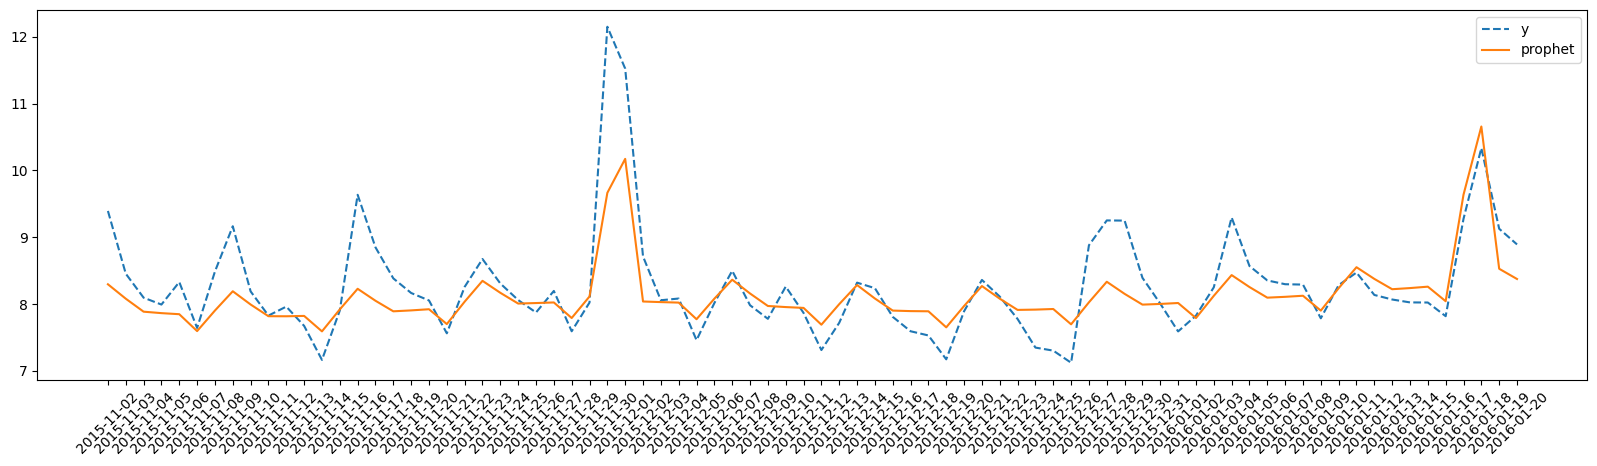

In [6]:

tt = test[test.ds>'2015-11-01']
print(np.mean(abs(tt['y']-tt['yhat']) / tt['y']))
plt.figure().set_figwidth(20)
plt.plot(tt.ds,tt.y,linestyle = '--', label = 'y')
plt.plot(tt.ds,tt.yhat,linestyle ='-', label = 'prophet')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [7]:
# future['on_season'] = future['ds'].apply(is_nfl_season)
# future['off_season'] = ~future['ds'].apply(is_nfl_season)
# future['nfl_sunday'] = future['ds'].apply(nfl_sunday)
# future
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')


  0%|          | 0/10 [00:00<?, ?it/s]

09:24:29 - cmdstanpy - INFO - Chain [1] start processing
09:24:30 - cmdstanpy - INFO - Chain [1] done processing
09:24:30 - cmdstanpy - INFO - Chain [1] start processing
09:24:30 - cmdstanpy - INFO - Chain [1] done processing
09:24:30 - cmdstanpy - INFO - Chain [1] start processing
09:24:31 - cmdstanpy - INFO - Chain [1] done processing
09:24:31 - cmdstanpy - INFO - Chain [1] start processing
09:24:31 - cmdstanpy - INFO - Chain [1] done processing
09:24:31 - cmdstanpy - INFO - Chain [1] start processing
09:24:32 - cmdstanpy - INFO - Chain [1] done processing
09:24:32 - cmdstanpy - INFO - Chain [1] start processing
09:24:32 - cmdstanpy - INFO - Chain [1] done processing
09:24:33 - cmdstanpy - INFO - Chain [1] start processing
09:24:33 - cmdstanpy - INFO - Chain [1] done processing
09:24:33 - cmdstanpy - INFO - Chain [1] start processing
09:24:34 - cmdstanpy - INFO - Chain [1] done processing
09:24:34 - cmdstanpy - INFO - Chain [1] start processing
09:24:34 - cmdstanpy - INFO - Chain [1]

In [9]:
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')



  0%|          | 0/3 [00:00<?, ?it/s]

09:40:30 - cmdstanpy - INFO - Chain [1] start processing
09:40:30 - cmdstanpy - INFO - Chain [1] done processing
09:40:31 - cmdstanpy - INFO - Chain [1] start processing
09:40:31 - cmdstanpy - INFO - Chain [1] done processing
09:40:32 - cmdstanpy - INFO - Chain [1] start processing
09:40:32 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.436803,0.660911,0.484317,0.056234,0.048210,0.056557,0.665746
1,38 days,0.452875,0.672960,0.487048,0.056427,0.048013,0.056875,0.672652
2,39 days,0.459303,0.677719,0.492699,0.057070,0.048723,0.057579,0.672652
3,40 days,0.483566,0.695389,0.499670,0.057751,0.048210,0.058386,0.669890
4,41 days,0.491989,0.701419,0.503225,0.058114,0.048210,0.058815,0.671271
...,...,...,...,...,...,...,...,...
324,361 days,1.034015,1.016865,0.834096,0.100635,0.087089,0.099871,0.482320
325,362 days,1.071176,1.034976,0.847303,0.101780,0.087089,0.101040,0.482320
326,363 days,1.088093,1.043117,0.855268,0.102560,0.087644,0.101758,0.481215
327,364 days,1.104158,1.050789,0.860589,0.103158,0.087412,0.102220,0.479558


c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],


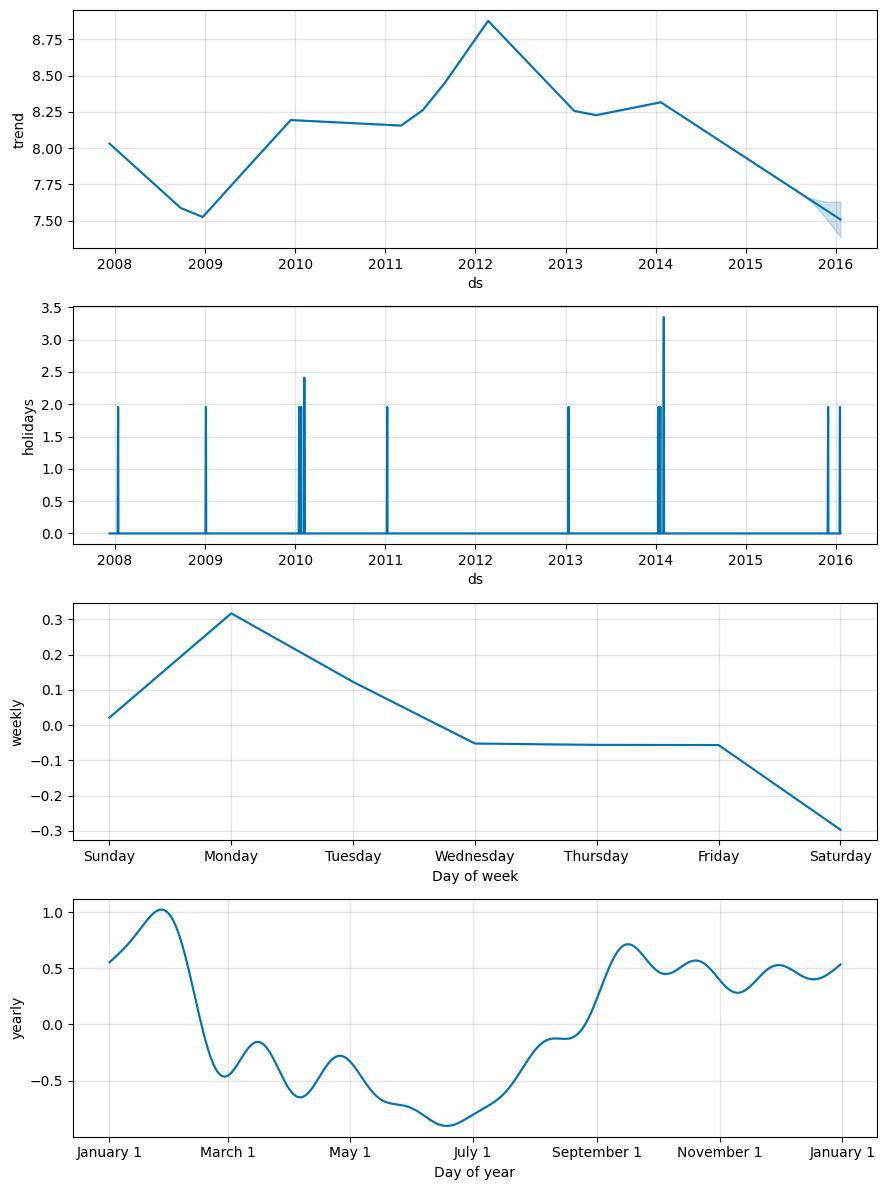

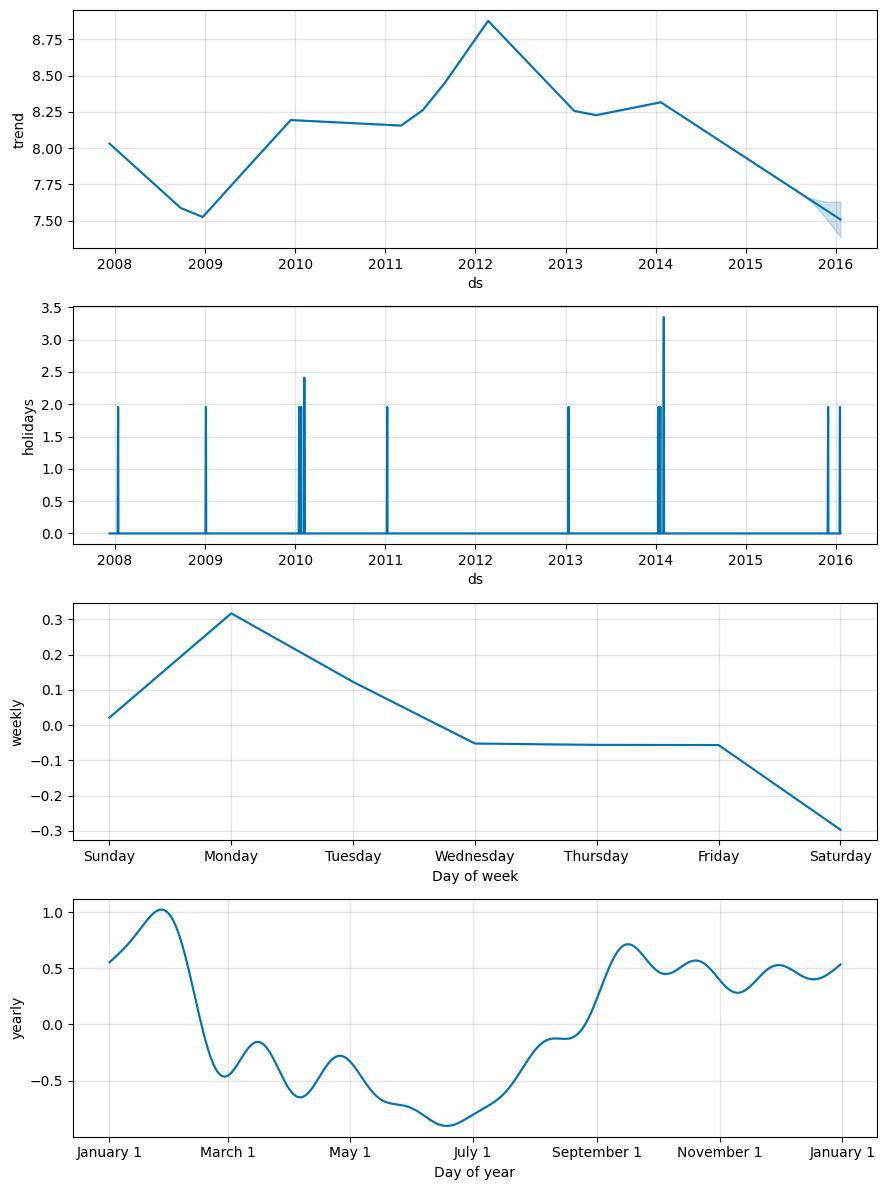

In [135]:
# tt[tt.ds>'2016-01-01']
m.train_holiday_names
m.plot_components(forecast)


c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


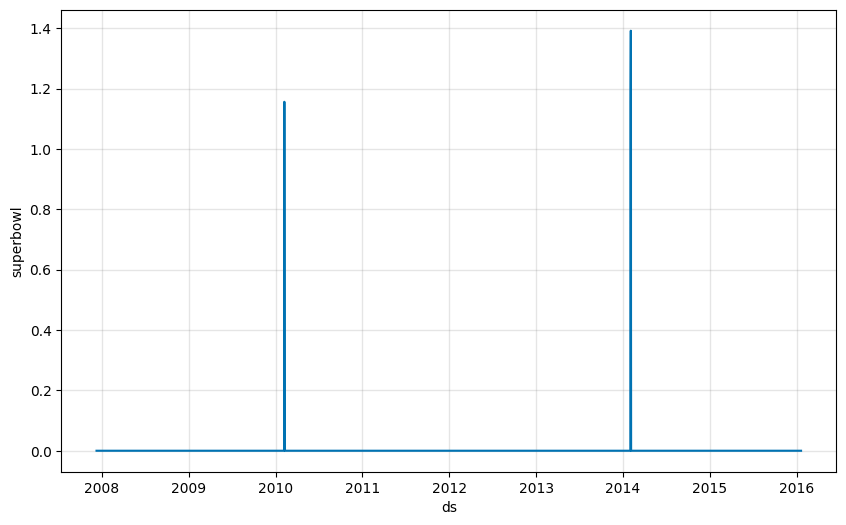

In [136]:
###Individual holidays can be plotted
from prophet.plot import plot_forecast_component
plot_forecast_component(m, forecast, 'superbowl')

c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

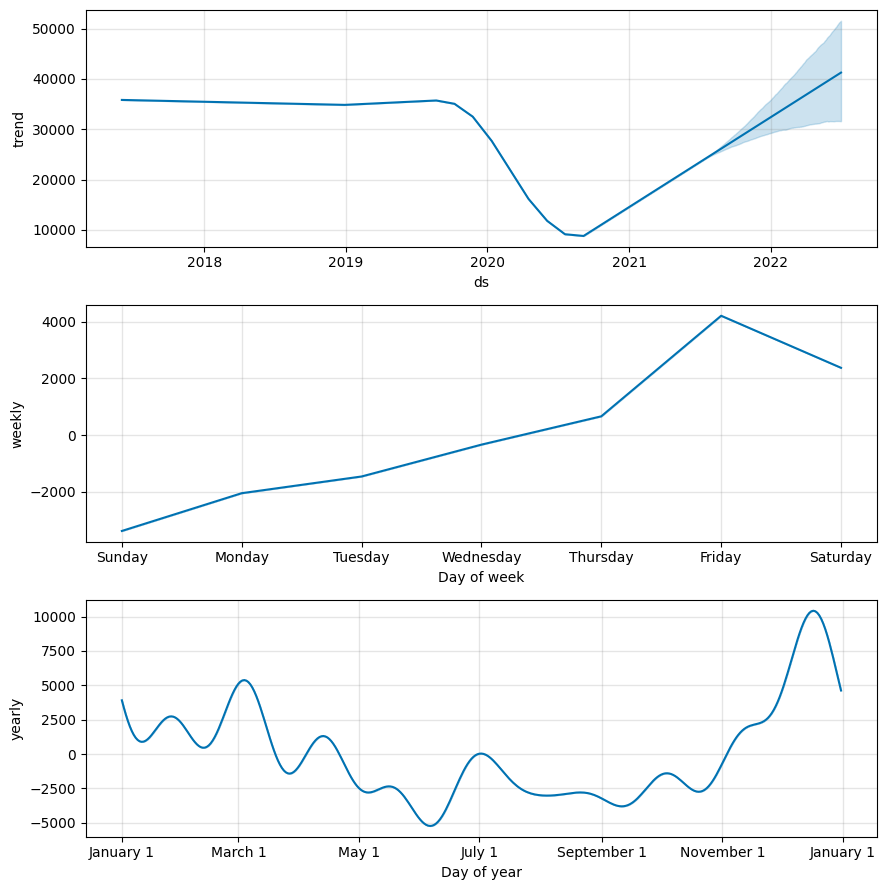

In [20]:
m.plot_components(forecast);


In [82]:
from prophet.make_holidays import make_holidays_df

nsw_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='US'
)
nsw_holidays

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-05-27,Memorial Day
2,2019-07-04,Independence Day
3,2019-09-02,Labor Day
4,2019-11-11,Veterans Day
...,...,...
118,2028-11-23,Thanksgiving
119,2028-12-25,Christmas Day
120,2028-01-17,Martin Luther King Jr. Day
121,2028-02-21,Washington's Birthday


In [34]:
make_holidays_df(
    year_list=[2025 + i for i in range(1)], country='Canada'
)

,ds,holiday
0,2025-01-01,New Year's Day
1,2025-04-18,Good Friday
2,2025-07-01,Canada Day
3,2025-09-01,Labor Day
4,2025-12-25,Christmas Day


# Handling Shocks

<Axes: xlabel='ds'>

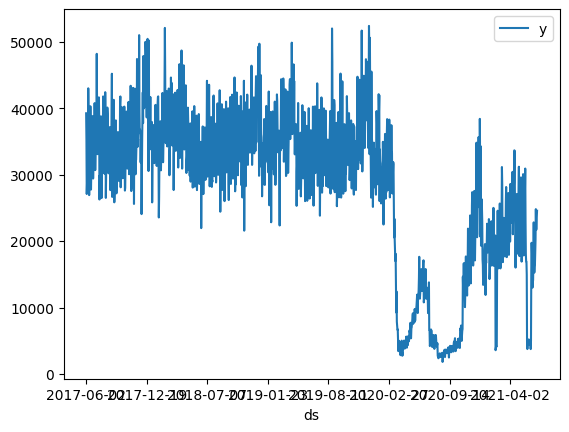

In [21]:
# Python
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv')

df.set_index('ds').plot()

16:32:00 - cmdstanpy - INFO - Chain [1] start processing
16:32:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(0.5, 1.0, 'Default Prophet')

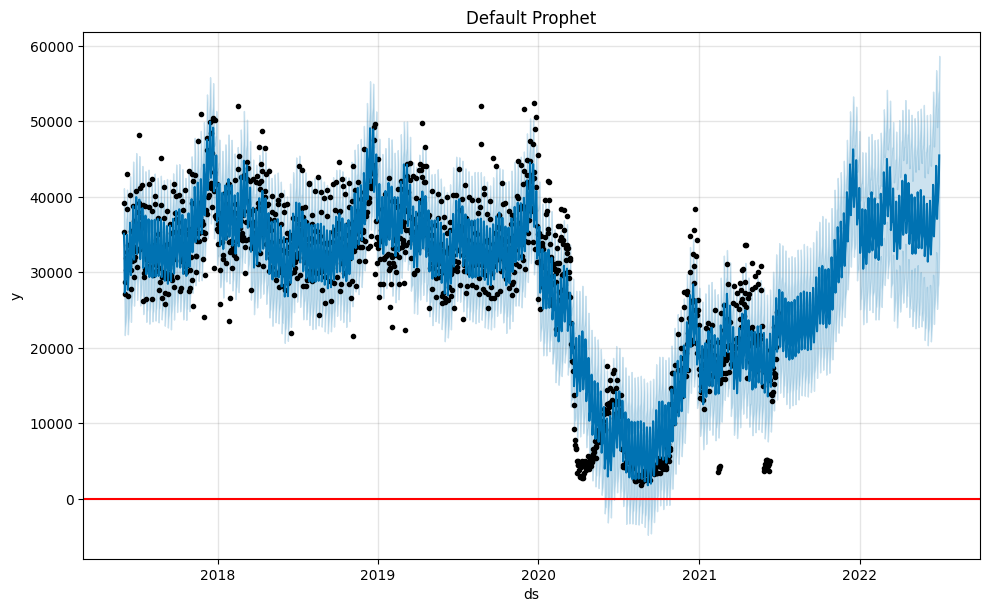

In [23]:
m = Prophet()
m = m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Default Prophet')

In [26]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns


,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


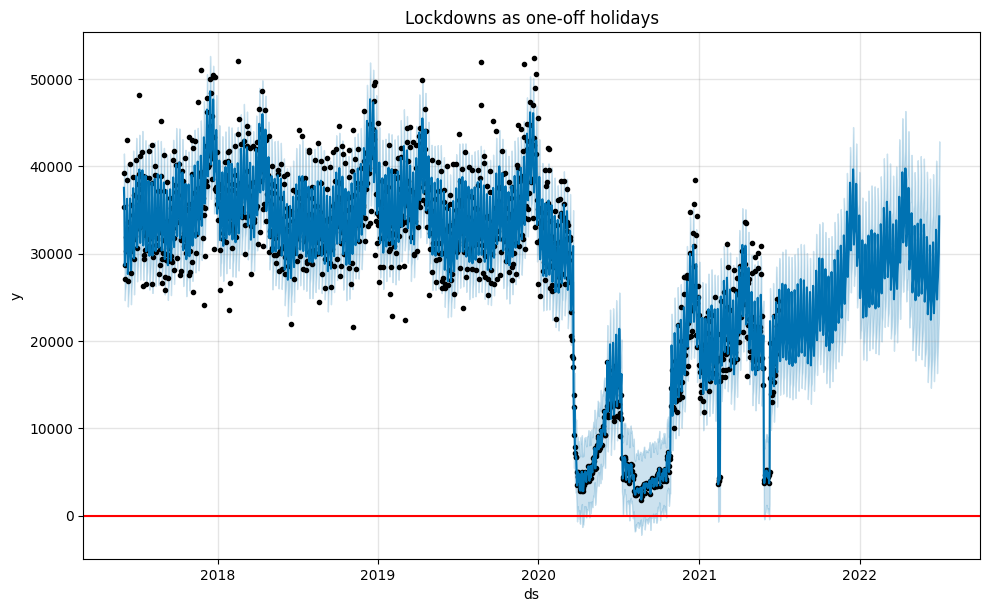

In [28]:
m2 = Prophet(holidays=lockdowns)
m2 = m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)
forecast2 = m2.predict(future2)

m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');


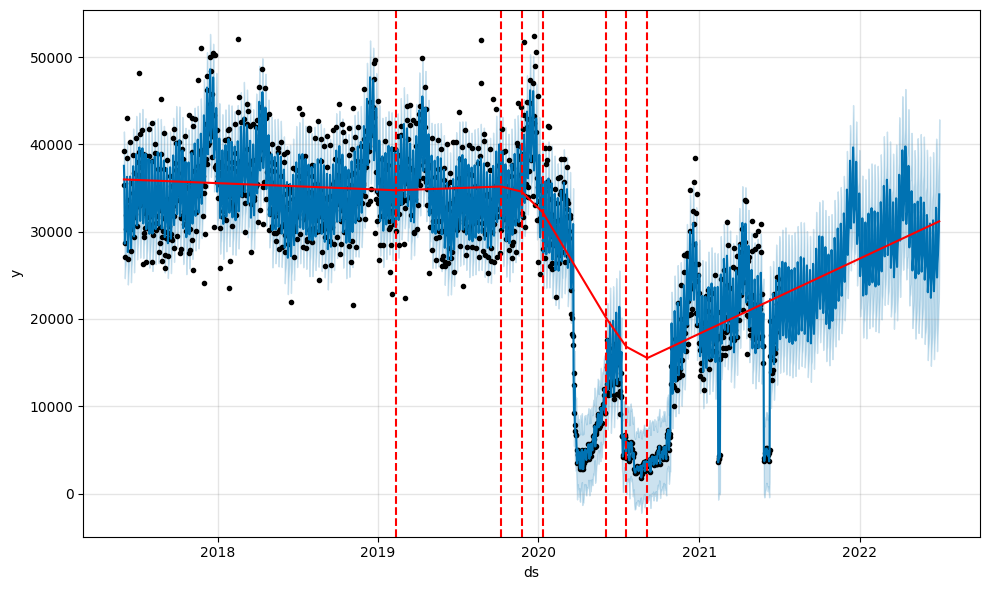

In [29]:
from prophet.plot import add_changepoints_to_plot
fig = m2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)


16:33:43 - cmdstanpy - INFO - Chain [1] start processing
16:33:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


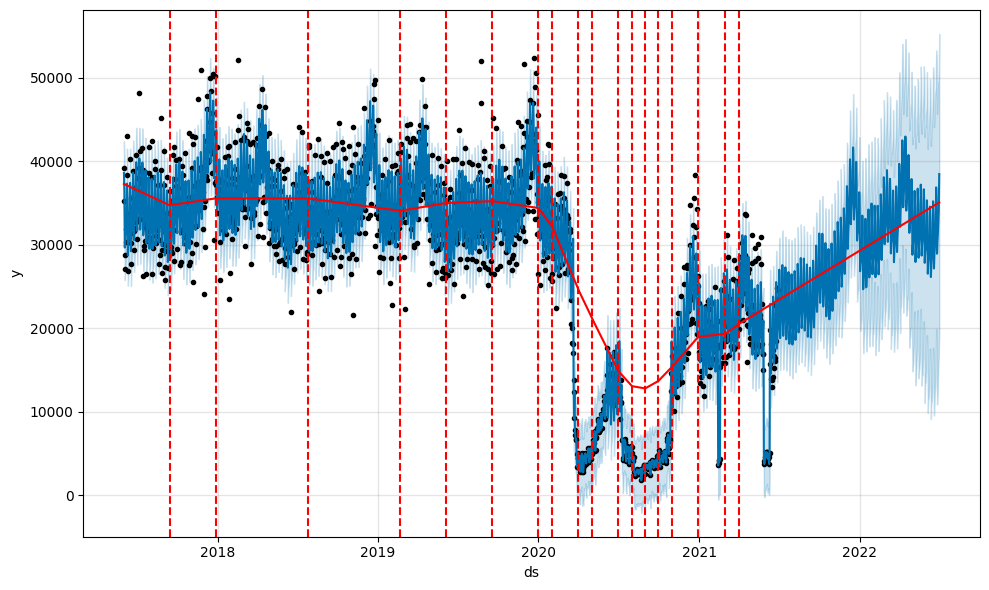

In [30]:
m3_changepoints = (
    # 10 potential changepoints in 2.5 years
    pd.date_range('2017-06-02', '2020-01-01', periods=10).date.tolist() + 
    # 15 potential changepoints in 1 year 2 months
    pd.date_range('2020-02-01', '2021-04-01', periods=15).date.tolist()
)

# Default changepoint_prior_scale is 0.05, so 1.0 will lead to much more flexibility in comparison.
m3 = Prophet(holidays=lockdowns, changepoints=m3_changepoints, changepoint_prior_scale=1.0)
m3 = m3.fit(df)
forecast3 = m3.predict(future2)

from prophet.plot import add_changepoints_to_plot
fig = m3.plot(forecast3)
a = add_changepoints_to_plot(fig.gca(), m3, forecast3)


,ds,y,pre_covid,post_covid
0,2017-06-02,39230,True,False
1,2017-06-03,35290,True,False
2,2017-06-04,27083,True,False
3,2017-06-05,28727,True,False
4,2017-06-06,30315,True,False


16:42:59 - cmdstanpy - INFO - Chain [1] start processing
16:43:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Schen1\Anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(0.5, 1.0, 'Lockdowns as one-off holidays + Conditional weekly seasonality')

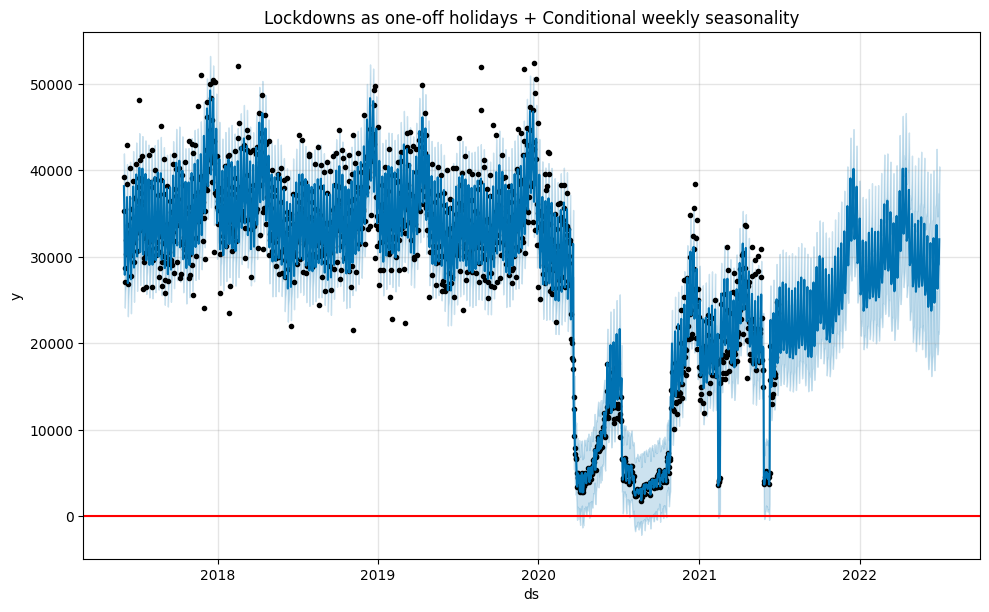

In [39]:
df2 = df.copy()
df2['pre_covid'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2020-03-21')
df2['post_covid'] = ~df2['pre_covid']

m4 = Prophet(holidays=lockdowns, weekly_seasonality=False)
df2.head()

m4.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m4.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)

m4 = m4.fit(df2)

future4 = m4.make_future_dataframe(periods=366)
future4['pre_covid'] = pd.to_datetime(future4['ds']) < pd.to_datetime('2020-03-21')
future4['post_covid'] = ~future4['pre_covid']

forecast4 = m4.predict(future4)


m4.plot(forecast4)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality')

In [43]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

AssertionError: No extra regressors found.

# XGboost

>expected=42.0, predicted=39.7
>expected=53.0, predicted=44.9
>expected=39.0, predicted=40.7
>expected=40.0, predicted=34.3
>expected=38.0, predicted=42.5
>expected=44.0, predicted=51.1
>expected=34.0, predicted=39.0
>expected=37.0, predicted=36.0
>expected=52.0, predicted=37.0
>expected=48.0, predicted=42.6
>expected=55.0, predicted=44.7
>expected=50.0, predicted=53.0
MAE: 5.745


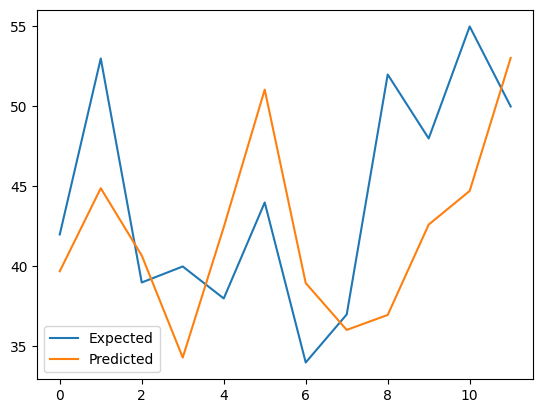

In [25]:
################### https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# load the dataset
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',header=0,index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()


In [28]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# load the dataset
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',header=0,index_col=0)
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(np.asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [34 37 52 48 55 50], Predicted: 40.690


In [30]:
values[-6:]

array([[34],
       [37],
       [52],
       [48],
       [55],
       [50]], dtype=int64)

In [32]:
trainX

array([[35., 32., 30., 31., 44., 29.],
       [32., 30., 31., 44., 29., 45.],
       [30., 31., 44., 29., 45., 43.],
       ...,
       [40., 38., 44., 34., 37., 52.],
       [38., 44., 34., 37., 52., 48.],
       [44., 34., 37., 52., 48., 55.]])

In [85]:
sf0 = sf[sf.IsComplete==0]
ecs0 = ecs[ecs.IsComplete==0]

ids = [i for i in list(sf0.Id) if i not in list(ecs0.Id)]
len(ids)

1231

In [86]:
tsf = sf0[sf0.Id.isin(ids)][['Id', 'ModifiedDate','IsComplete']]
tecs = ecs[ecs.Id.isin(ids)][['Id', 'ModifiedDate','IsComplete']]

df = tsf.merge(tecs,on='Id',how='left')

In [88]:
df.to_csv('asdf.csv')